In [3]:
!pip install seaborn

from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


In [4]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)


2.7.0


In [5]:
dataset_path = keras.utils.get_file("housing.data","http://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data")
dataset_path

column_names = ['CRIM','ZN','INDUS','CHAS','NOX','RM', 'DIS', 'RAD', 'TAX','PTRATIO', 'B', 'MEDV']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                          na_values = "?", comment='\t',
                          sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()

57344/49082 [===================================] - 0s 2us/step


In [6]:
dataset.isna().sum()
dataset = dataset.dropna()

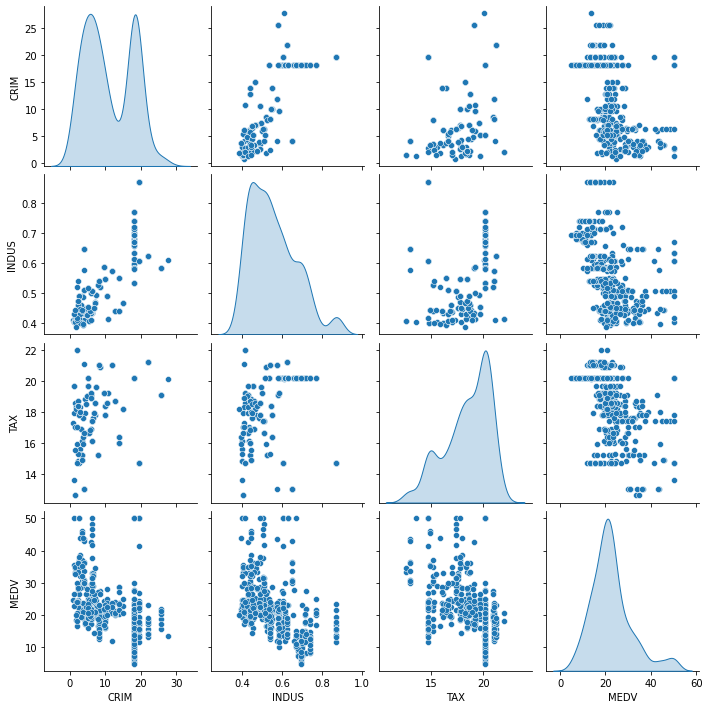

In [7]:
#split trained and tested data
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)
sns.pairplot(train_dataset[["CRIM", "INDUS", "TAX", "MEDV"]],
             diag_kind="kde")


In [8]:
train_stats = train_dataset.describe()
train_stats.pop("MEDV")
train_stats = train_stats.transpose()
train_stats


,count,mean,std,min,25%,50%,75%,max
CRIM,405.0,11.097951,6.699157,0.7400,5.3200,9.6900,18.1000,27.7400
ZN,405.0,0.069136,0.253999,0.0000,0.0000,0.0000,0.0000,1.0000
INDUS,405.0,0.553098,0.115564,0.3850,0.4490,0.5380,0.6240,0.8710
CHAS,405.0,6.269768,0.690552,3.5610,5.8780,6.1930,6.6190,8.7800
NOX,405.0,68.241975,27.908527,2.9000,45.0000,76.5000,94.1000,100.0000
RM,405.0,3.834098,2.162173,1.1296,2.0788,3.2721,5.2146,12.1265
DIS,405.0,9.474074,8.618564,1.0000,4.0000,5.0000,24.0000,24.0000
RAD,405.0,405.839506,164.057951,187.0000,284.0000,334.0000,666.0000,711.0000
TAX,405.0,18.437037,2.141275,12.6000,17.3000,18.8000,20.2000,22.0000
PTRATIO,405.0,356.276444,91.298597,2.6000,375.2100,391.2300,396.2400,396.9000


In [9]:
train_labels = train_dataset.pop('MEDV')
test_labels = test_dataset.pop('MEDV')


In [10]:
#normalized the data
def norm(x):
 return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)



In [11]:
normed_train_data.tail()

,,CRIM,ZN,INDUS,CHAS,NOX,RM,DIS,RAD,TAX,PTRATIO,B
0.21038,20.0,-1.159542,-0.27219,-0.953564,0.785216,-1.291432,0.123303,-0.519121,-1.157149,-1.651837,0.444953,-1.098534
0.41238,0.0,-0.731129,-0.27219,-0.424853,1.293505,0.417723,-0.286008,-0.171035,-0.602467,-0.484308,0.173097,-0.885566
2.33099,0.0,1.266137,-0.27219,2.750874,-1.569423,0.915778,-1.065825,-0.519121,-0.017308,-1.745239,0.007816,2.211631
4.09740,0.0,1.266137,-0.27219,2.750874,-1.161054,1.137933,-1.120307,-0.519121,-0.017308,-1.745239,0.444953,1.943659
0.03738,0.0,-0.881895,-0.27219,-0.329668,0.058261,-1.065695,1.213734,-0.519121,-1.108386,0.823324,0.362805,-0.830561


In [12]:
normed_test_data.tail()

,,CRIM,ZN,INDUS,CHAS,NOX,RM,DIS,RAD,TAX,PTRATIO,B
0.15086,0.0,2.484201,-0.27219,0.483734,-1.181328,0.876364,-0.931099,-0.635149,1.860077,0.776623,0.425128,0.764580
0.18337,0.0,2.484201,-0.27219,0.483734,-1.239252,1.077019,-0.961393,-0.635149,1.860077,0.776623,-0.133917,1.598115
0.20746,0.0,2.484201,-0.27219,0.483734,-1.704098,1.066270,-0.930313,-0.635149,1.860077,0.776623,-0.414535,2.403443
0.11132,0.0,2.484201,-0.27219,0.483734,-0.415274,0.546716,-0.797438,-0.635149,1.860077,0.776623,0.444953,0.100290
0.10959,0.0,0.124202,-0.27219,0.172218,0.759150,0.754537,-0.668401,-0.983235,-0.809711,1.196933,0.407165,-0.868642


In [13]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu',
                 input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
   ])
  
  optimizer = tf.keras.optimizers.RMSprop(0.001)
  model.compile(loss='mse',
              optimizer=optimizer,
              metrics=['mae', 'mse'])
  return model


In [14]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                768       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,993
Trainable params: 4,993
Non-trainable params: 0
_________________________________________________________________


In [15]:
class PrintDot(keras.callbacks.Callback):
 def on_epoch_end(self, epoch, logs):
  if epoch % 100 == 0: print('')
  print('.', end='')

EPOCHS = 10000
history = model.fit(
 normed_train_data, train_labels,
 epochs=EPOCHS, validation_split = 0.2, verbose=0,
 callbacks=[PrintDot()])



....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [16]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()


,loss,mae,mse,val_loss,val_mae,val_mse,epoch
9995,0.080378,0.226281,0.080378,17.770254,2.975565,17.770254,9995
9996,0.073987,0.206469,0.073987,18.568321,2.994218,18.568321,9996
9997,0.136580,0.291073,0.136580,19.193321,2.990591,19.193321,9997
9998,0.081912,0.221611,0.081912,18.743708,2.968993,18.743708,9998
9999,0.059745,0.179337,0.059745,20.300148,3.126271,20.300148,9999


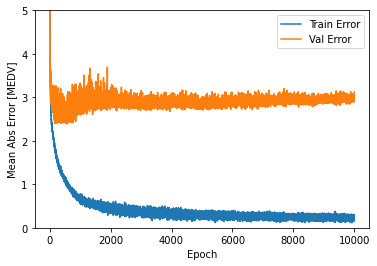

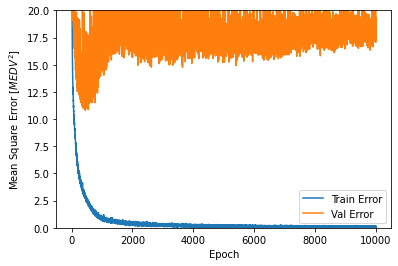

In [17]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MEDV]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MEDV^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

plot_history(history)


ปรับปรุงโมเดล (Tuning Model)

In [18]:
def build_model():
  model = keras.Sequential([
    layers.Dense(128, activation='relu', 
input_shape=[len(train_dataset.keys())]),
    layers.Dropout(.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(.5),
    layers.Dense(1)
   ])
  
  optimizer = tf.keras.optimizers.RMSprop(0.001)
  model.compile(loss='mse',
              optimizer=optimizer,
              metrics=['mae', 'mse'])
  return model



In [19]:
model = build_model()
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               1536      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                

In [20]:
class PrintDot(keras.callbacks.Callback):
 def on_epoch_end(self, epoch, logs):
  if epoch % 100 == 0: print('')
  print('.', end='')

EPOCHS = 10000
history = model.fit(
 normed_train_data, train_labels,
 epochs=EPOCHS, validation_split = 0.2, verbose=0,
 callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

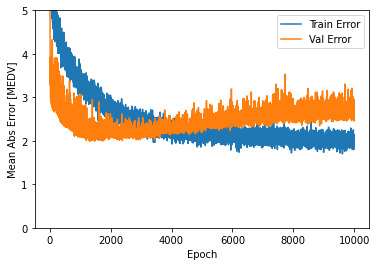

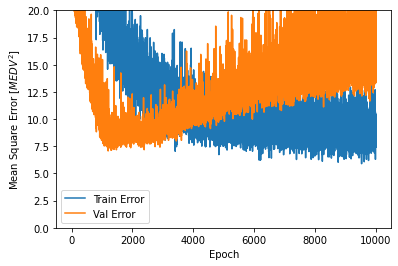

In [21]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MEDV]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MEDV^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

plot_history(history)


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

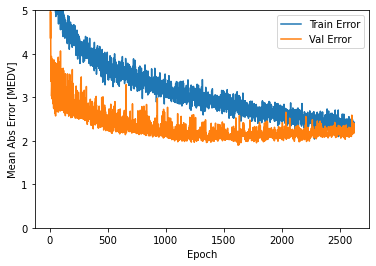

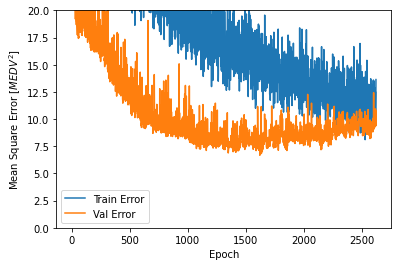

In [22]:
model = build_model()
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',
                                           patience=1000)
history = model.fit(
 normed_train_data, train_labels,
 epochs=EPOCHS, validation_split = 0.2, verbose=0,
 callbacks=[early_stop,PrintDot()])
plot_history(history)


In [23]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose = 0)
print("Testing set Mean Abs Error: {:5.2f} MEDV".format(mae))


Testing set Mean Abs Error:  2.02 MEDV


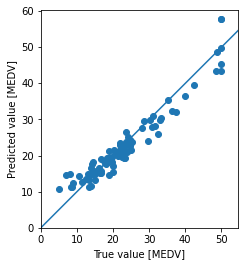

In [24]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True value [MEDV]')
plt.ylabel('Predicted value [MEDV]')
plt.axis('equal')
plt.axis('square')
plt.xlim(0,plt.xlim()[1])
plt.ylim(0,plt.ylim()[1])
_ = plt.plot([-100,100],[-100,100])


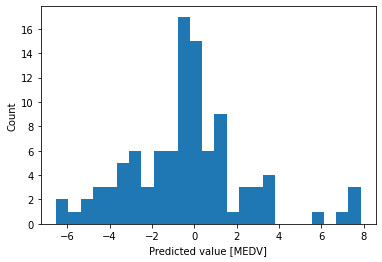

In [25]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel('Predicted value [MEDV]')
_ = plt.ylabel('Count')
